# HW2 - Home Loan Default Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# load data
path = './LoanData/LoanDefaultData.csv'
df_ini = pd.read_csv(path)

print(df_ini.shape)
df_ini.head()

(80000, 89)


,Unnamed: 0.1,Unnamed: 0,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,2,3,3,0,33,1,4,12,2017/7/1 14:11,h5,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,3,4,4,0,34,2,4,12,2017/7/7 10:10,android,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,4,5,5,0,47,2,1,12,2017/7/6 14:37,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


## feature selection

I picked these features first because they seem directly connected to default risk.

- `CR*`: credit/bureau behavior
- `TD*`: transaction + repayment patterns
- `PA*` (tested later): extra behavior signal

So my approach was: start with business-sense features, then check model results and improve recall for defaulters.

In [3]:
features1 = ['CR004','CR005','CR009','CR012','CR015','CR017','CR018','CR019','TD001','TD002','TD005']
features2 = ['CR004','CR005','CR009','CR012','CR015','CR017','CR018','CR019','PA022','PA023','PA028','TD001','TD002','TD005']

cols = ['loan_default'] + features1
df = df_ini[cols].copy()
df.head()

,loan_default,CR004,CR005,CR009,CR012,CR015,CR017,CR018,CR019,TD001,TD002,TD005
0,1,2,1,35807,0,4,4,3,2,1,1,4
1,0,3,1,7254,0,6,7,6,11,2,0,3
2,0,2,2,30377,0,2,2,2,3,2,1,4
3,0,2,1,0,0,5,7,7,8,0,0,0
4,0,4,2,0,0,6,8,7,11,2,0,2


In [4]:
# handle missing values and sentinel missing codes
df.replace([-99, -98, -1, -999, -9999, ''], np.nan, inplace=True)

df.isna().mean().sort_values(ascending=False)

loan_default    0.0
CR004           0.0
CR005           0.0
CR009           0.0
CR012           0.0
CR015           0.0
CR017           0.0
CR018           0.0
CR019           0.0
TD001           0.0
TD002           0.0
TD005           0.0
dtype: float64

In [5]:
# split data and impute with median
X = df.drop('loan_default', axis=1)
y = df['loan_default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

med = X_train.median(numeric_only=True)
X_train_imp = X_train.fillna(med)
X_test_imp = X_test.fillna(med)

## Logistic Regression

In [6]:
# logistic regression (imbalanced)
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_imp, y_train)
y_pred = logreg.predict(X_test_imp)

print('Accuracy:', logreg.score(X_test_imp, y_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.806125

Confusion Matrix:
[[12889    13]
 [ 3089     9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     12902
           1       0.41      0.00      0.01      3098

    accuracy                           0.81     16000
   macro avg       0.61      0.50      0.45     16000
weighted avg       0.73      0.81      0.72     16000



### observation (baseline logistic)

Accuracy looks okay at first, but recall for defaulters is very low.

So this model is mostly predicting the majority class (`loan_default = 0`).
That means accuracy alone is misleading here.

In [7]:
# logistic regression with higher iterations
logreg_iter = LogisticRegression(max_iter=6000)
logreg_iter.fit(X_train_imp, y_train)
y_pred = logreg_iter.predict(X_test_imp)

print('Accuracy:', logreg_iter.score(X_test_imp, y_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.806125

Confusion Matrix:
[[12889    13]
 [ 3089     9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     12902
           1       0.41      0.00      0.01      3098

    accuracy                           0.81     16000
   macro avg       0.61      0.50      0.45     16000
weighted avg       0.73      0.81      0.72     16000



### observation (more iterations)

I increased `max_iter` to see if convergence was the issue.

Result: almost no real recall improvement for class `1`.
So the main issue is class imbalance, not iteration count.

In [8]:
# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

logreg_scaled = LogisticRegression(max_iter=2000)
logreg_scaled.fit(X_train_scaled, y_train)
y_pred = logreg_scaled.predict(X_test_scaled)

print('Accuracy:', logreg_scaled.score(X_test_scaled, y_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.8061875

Confusion Matrix:
[[12889    13]
 [ 3088    10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     12902
           1       0.43      0.00      0.01      3098

    accuracy                           0.81     16000
   macro avg       0.62      0.50      0.45     16000
weighted avg       0.73      0.81      0.72     16000



### observation (scaled logistic)

I scaled the features since the columns are on different ranges.

It helps training stability, but by itself it still does not fix low default recall.

In [9]:
# logistic regression with class_weight balanced
logreg_bal = LogisticRegression(max_iter=2000, class_weight='balanced')
logreg_bal.fit(X_train_scaled, y_train)
y_pred = logreg_bal.predict(X_test_scaled)

print('Accuracy:', logreg_bal.score(X_test_scaled, y_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.617125

Confusion Matrix:
[[8257 4645]
 [1481 1617]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.64      0.73     12902
           1       0.26      0.52      0.35      3098

    accuracy                           0.62     16000
   macro avg       0.55      0.58      0.54     16000
weighted avg       0.73      0.62      0.66     16000



### improvement (balanced logistic)

This is the first change that clearly helps with what matters most here: catching defaulters.

`class_weight='balanced'` may reduce overall accuracy, but it improves default recall, which is more useful for this assignment.

## KNN

In [10]:
# KNN baseline
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print('Accuracy:', knn.score(X_test_scaled, y_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.752375

Confusion Matrix:
[[11664  1238]
 [ 2724   374]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85     12902
           1       0.23      0.12      0.16      3098

    accuracy                           0.75     16000
   macro avg       0.52      0.51      0.51     16000
weighted avg       0.70      0.75      0.72     16000



In [11]:
# KNN tuning by k: monitor train accuracy, test accuracy, and default recall
neighbors = np.arange(1, 11)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
recall_default = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    train_accuracy[i] = knn.score(X_train_scaled, y_train)
    test_accuracy[i] = knn.score(X_test_scaled, y_test)

    y_pred = knn.predict(X_test_scaled)
    recall_default[i] = classification_report(y_test, y_pred, output_dict=True)['1']['recall']

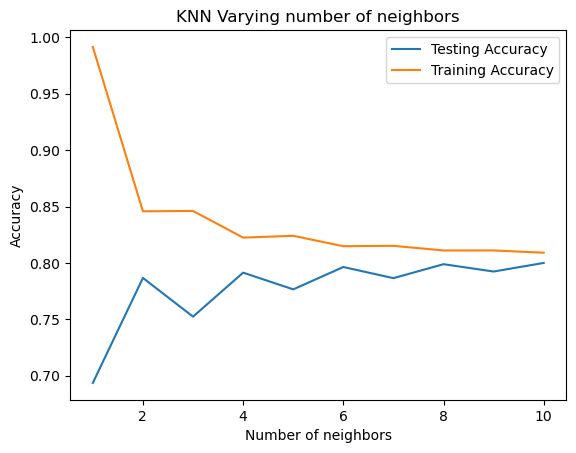

In [12]:
plt.title('KNN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

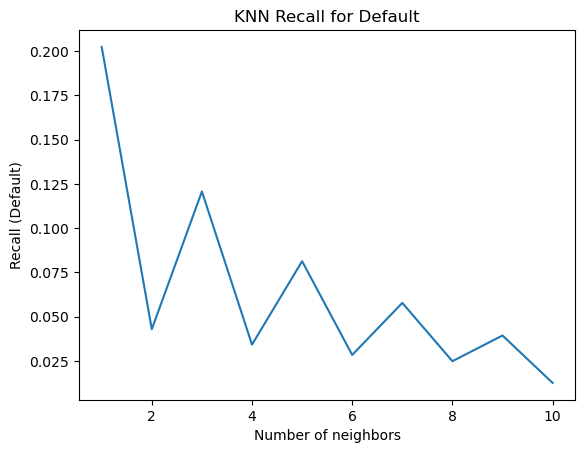

In [13]:
plt.title('KNN Recall for Default')
plt.plot(neighbors, recall_default)
plt.xlabel('Number of neighbors')
plt.ylabel('Recall (Default)')
plt.show()

### KNN interpretation

From the plots, I can see the tradeoff clearly:

- bigger `k` can make accuracy look better,
- but recall for class `1` can drop.

So I picked `k` based more on recall/F1 for defaulters, not just highest accuracy.

In [14]:
# choose a k that gives better recall tradeoff
knn_best = KNeighborsClassifier(n_neighbors=5)
knn_best.fit(X_train_scaled, y_train)
y_pred = knn_best.predict(X_test_scaled)

print('Accuracy:', knn_best.score(X_test_scaled, y_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.7765625

Confusion Matrix:
[[12173   729]
 [ 2846   252]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     12902
           1       0.26      0.08      0.12      3098

    accuracy                           0.78     16000
   macro avg       0.53      0.51      0.50     16000
weighted avg       0.70      0.78      0.73     16000



## Naive Bayes

In [15]:
# Naive Bayes (not normalized)
nb = GaussianNB()
nb.fit(X_train_imp, y_train)
y_pred = nb.predict(X_test_imp)

print('Accuracy:', nb.score(X_test_imp, y_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.803

Confusion Matrix:
[[12733   169]
 [ 2983   115]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     12902
           1       0.40      0.04      0.07      3098

    accuracy                           0.80     16000
   macro avg       0.61      0.51      0.48     16000
weighted avg       0.73      0.80      0.73     16000



In [16]:
# Naive Bayes (normalized)
nb_scaled = GaussianNB()
nb_scaled.fit(X_train_scaled, y_train)
y_pred = nb_scaled.predict(X_test_scaled)

print('Accuracy:', nb_scaled.score(X_test_scaled, y_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.77475

Confusion Matrix:
[[11995   907]
 [ 2697   401]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     12902
           1       0.31      0.13      0.18      3098

    accuracy                           0.77     16000
   macro avg       0.56      0.53      0.53     16000
weighted avg       0.72      0.77      0.74     16000



### Naive Bayes thought process

I tested Naive Bayes in a few ways without scaling, with scaling and with a different feature set + custom priors.

I did this to see if I could improve defaulter detection, even if overall accuracy drops a bit.

In [17]:
# Naive Bayes with alternate feature set and balanced priors
target = 'loan_default'
df2 = df_ini[[target] + features2].copy()
df2.replace([-99, -98, -1, -999, -9999, ''], np.nan, inplace=True)

X2 = df2.drop(target, axis=1)
y2 = df2[target]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

med2 = X2_train.median(numeric_only=True)
X2_train_imp = X2_train.fillna(med2)
X2_test_imp = X2_test.fillna(med2)

nb2 = GaussianNB(priors=[0.5, 0.5])
nb2.fit(X2_train_imp, y2_train)
y2_pred = nb2.predict(X2_test_imp)

print('Accuracy:', nb2.score(X2_test_imp, y2_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y2_test, y2_pred))
print('\nClassification Report:')
print(classification_report(y2_test, y2_pred))

Accuracy: 0.64425

Confusion Matrix:
[[8915 3987]
 [1705 1393]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.69      0.76     12902
           1       0.26      0.45      0.33      3098

    accuracy                           0.64     16000
   macro avg       0.55      0.57      0.54     16000
weighted avg       0.73      0.64      0.67     16000



## final summary

After testing multiple versions of all 3 required models, this is my main conclusion:

This dataset is imbalanced, so accuracy by itself is not enough.

What I learned:

- Logistic Regression: high baseline accuracy, but poor recall for defaulters; balancing class weights helps a lot.
- KNN: very sensitive to `k`; I should pick based on recall/F1 for class `1`, not only accuracy.
- Naive Bayes: changing features/priors can improve recall, but usually with some accuracy tradeoff.

So for this assignment, I would choose the model setup that gives the best recall/F1 for defaulters, even if it is not the top-accuracy model.